# Model 3: Scenario & Robustness Analysis

Building on Model 2's dynamic framework, this 
model introduces "what-if" scenarios to test the strategy's robustness against key uncertainties. 
It evaluates performance against risks like volatile resource prices and increased bidding 
competition. The analysis also incorporates major policy and  environmental variables by 
modelling the financial impact of a new, tech-specific carbon tax. Finally, it simulates weather-
driven revenue fluctuations for renewables by applying variable capacity factors (good vs. bad 
years) to the revenue streams.

##### Notebook Outline
1) Imports
2) Load Input Data
3) Scenario Parameters
4) Gurobi Model Setup
5) Results
6) Visualizations

### Imports

In [81]:
import json
from pathlib import Path
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

### Load input data

In [82]:
# technology data
data_path = Path("data") / "technology_data.json"

with data_path.open("r", encoding="utf-8") as f:
    technology_data = json.load(f)

TECHNOLOGY_UNITS = technology_data["TECHNOLOGY_UNITS"]  
TECHNOLOGY_DATA = technology_data["TECHNOLOGY_DATA"]

df_units = pd.DataFrame(list(TECHNOLOGY_UNITS.items()), columns=["Parameter", "Unit"])
df_tech = pd.DataFrame(TECHNOLOGY_DATA).reset_index().rename(columns={"index": "parameter"})
df = df_units.merge(df_tech, left_on="Parameter", right_on="parameter", how="right").drop(columns=["parameter"])
print("Technology Data:")
display(df)

# load electricity prices
price_data_path = Path("data") / "electricity_prices.xlsx"
df_prices = pd.read_excel(price_data_path)[["Year", "Price"]].iloc[:20]
df_prices["Year"] = df_prices["Year"].astype(int)
df_prices["Price"] = df_prices["Price"].astype(float)

exchange_rate = 7.4 # DKK to EUR
df_prices["Price"] = df_prices["Price"]/exchange_rate
price_list = df_prices["Price"].tolist()

df_display = df_prices.T
df_display.columns = df_prices["Year"].tolist()
df_display = df_display.drop("Year")
print("Electricity Prices (EUR/MWh):")
display(df_display)

# load co2 intensity for technologies
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "CO2 intensity": 0
}
costs = costs.value.unstack().fillna(defaults)

co2_intensity = {
    #"Gas turbine (simple cycle)": costs.at["gas", "CO2 intensity"],
    #"Natural gas engine plant":   costs.at["gas", "CO2 intensity"],
    "Diesel engine farm":         costs.at["gas", "CO2 intensity"]*1.2,
    "OCGT - Natural gas":         costs.at["gas", "CO2 intensity"],
    "Coal power plant":           costs.at["coal", "CO2 intensity"],
    "Nuclear power plant":        costs.at["nuclear", "CO2 intensity"],
    "Onshore wind":               costs.at["onwind", "CO2 intensity"],
    "Offshore wind (fixed)":      costs.at["offwind", "CO2 intensity"],
    "Utility-scale PV":           costs.at["solar-utility", "CO2 intensity"],
}

df_co2 = pd.DataFrame.from_dict(co2_intensity, orient="index", columns=["CO2 intensity (tCO2/MWh)"]).T
print("CO2 Intensity by Technology:")
display(df_co2)

Technology Data:


,Parameter,Unit,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
0,nominal_investment_total,MEUR/MW_el,0.36,0.47,2.10,4.000,1.150,2.390,0.38
1,fixed_om_total,EUR/MW/year,8983.37,8236.12,34324.40,147700.000,16663.000,34000.000,9500.00
2,variable_om_total,EUR/MWh,6.38,4.79,3.21,20.000,1.980,3.450,0.50
3,elec_eff,fraction (0-1),0.35,0.41,0.52,0.360,0.410,0.520,0.16
4,technical_lifetime,years,25.00,25.00,25.00,60.000,30.000,30.000,35.00
5,construction_time,years,1.00,0.20,4.50,8.000,1.500,3.500,0.50
6,total_outage,fraction of time (0-1),0.01,0.01,0.00,0.001,0.023,0.025,NaN


Electricity Prices (EUR/MWh):


,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044
Price,90.598127,88.152135,83.576931,82.826762,80.538427,79.397276,74.590121,67.366515,64.427126,62.897569,58.468283,59.1168,59.890278,60.807289,61.886407,63.146206,64.605259,66.28214,68.195421,70.363677


CO2 Intensity by Technology:


,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
CO2 intensity (tCO2/MWh),0.2376,0.198,0.3361,0.0,0.0,0.0,0.0


In [83]:
import pandas as pd

cost_list = costs.index.to_list()

# Search cost_list for items containing "diesel" (case-insensitive)
matches = [item for item in cost_list if "solar" in item.lower()]

print(f"Found {len(matches)} match(es):")
for m in matches:
    print(m)

# Optionally create a pandas Series for nicer display in the notebook
pd.Series(matches, name="technology")

Found 8 match(es):
central solar thermal
decentral solar thermal
solar
solar-rooftop
solar-rooftop commercial
solar-rooftop residential
solar-utility
solar-utility single-axis tracking


0                 central solar thermal
1               decentral solar thermal
2                                 solar
3                         solar-rooftop
4              solar-rooftop commercial
5             solar-rooftop residential
6                         solar-utility
7    solar-utility single-axis tracking
Name: technology, dtype: object

### Scenario Parameters

In [84]:
market_share = 0.35                               
num_periods = 20
time_periods = list(range(num_periods))
hours_per_year = 8760

initial_budget = 100                              # MEUR
base_demand = market_share * 35_250_000           # MWh
demand_growth_rate = 0.02                         # yearly growth

carbon_price = 83  # EUR/tCO2, taken from https://tradingeconomics.com/commodity/carbon
carbon_increase = 5  # EUR/tCO2 per year

# Maximum cumulative installed capacity per tech (MW)
max_capacity = {
    #"Gas turbine (simple cycle)": market_share*1500,
    #"Natural gas engine plant":   market_share*1500,
    "Diesel engine farm":         market_share*100,
    "OCGT - Natural gas":         market_share*2000,
    "Coal power plant":           market_share*1500,
    "Nuclear power plant":        market_share*1000,
    "Onshore wind":               market_share*3500,
    "Offshore wind (fixed)":      market_share*5000,
    "Utility-scale PV":           market_share*4000,
}

#### Preprocessing - build parameter dictionaries

In [85]:
tech_names = list(TECHNOLOGY_DATA.keys())

# --- Technical & economic parameters ---
capex = {tech: TECHNOLOGY_DATA[tech]['nominal_investment_total']
         for tech in tech_names}

elec_eff = {tech: TECHNOLOGY_DATA[tech]['elec_eff']
            for tech in tech_names}

vom_eur = {tech: TECHNOLOGY_DATA[tech]['variable_om_total']
           for tech in tech_names}

vom_meur = {tech: vom_eur[tech] / 1e6
            for tech in tech_names}

fixed_om_eur = {tech: TECHNOLOGY_DATA[tech]['fixed_om_total']
                for tech in tech_names}

fixed_om_meur = {tech: fixed_om_eur[tech] / 1e6
                 for tech in tech_names}

# --- Prices ---
price_eur = {t: price_list[t] for t in time_periods}
price_meur = {t: price_eur[t] / 1e6 for t in time_periods}

carbon_price_eur_per_tco2 = {
    t: carbon_price + carbon_increase*t     # EUR/tCO2
    for t in time_periods
}

carbon_price_meur_per_tco2 = {
    t: carbon_price_eur_per_tco2[t] / 1e6   # MEUR/tCO2
    for t in time_periods
}

# --- Demand curve ---
demand = {
    t: base_demand * ((1 + demand_growth_rate) ** t)
    for t in time_periods
}

### Gurobi Model Setup

#### Variables

In [86]:
model = gp.Model("Dynamic_Revenue_Maximization")

# Investment in new capacity [MW] in period t
investment = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Investment"
)

# Available capacity [MW] in period t (accumulated)
capacity = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Capacity"
)

# Energy produced [MWh] by tech in period t
energy = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Energy"
)

# Budget available in each period [MEUR]
budget = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="Budget"
)

# Auxiliary variables for accounting
revenue = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="Revenue"
)

# O&M and CAPEX costs
op_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="OperatingCost"
)

fixed_om_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="FixedOMCost"
)

capex_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="CapexCost"
)

co2_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="CO2Cost"
)

#### Model constraints

In [87]:
# Capacity accumulation
for tech in tech_names:
    model.addConstr(capacity[tech, 0] == investment[tech, 0])
    for t in time_periods[1:]:
        model.addConstr(
            capacity[tech, t] == capacity[tech, t-1] + investment[tech, t],
            name=f"CapacityAccum_{tech}_{t}"
        )

# Cumulative capacity limits
for tech in tech_names:
    if tech in max_capacity:
        for t in time_periods:
            model.addConstr(
                capacity[tech, t] <= max_capacity[tech],
                name=f"MaxCap_{tech}_{t}"
            )

# Production limited by capacity * efficiency * hours
for tech in tech_names:
    for t in time_periods:
        model.addConstr(
            energy[tech, t] <= capacity[tech, t] * elec_eff[tech] * hours_per_year,
            name=f"ProdCap_{tech}_{t}"
        )

# Define revenue, OPEX, CAPEX, fixed O&M
for t in time_periods:
    model.addConstr(
        revenue[t] == gp.quicksum(energy[tech, t] * price_meur[t] for tech in tech_names),
        name=f"RevenueDef_{t}"
    )

    model.addConstr(
        op_cost[t] == gp.quicksum(energy[tech, t] * vom_meur[tech] for tech in tech_names),
        name=f"OpCostDef_{t}"
    )

    model.addConstr(
        capex_cost[t] == gp.quicksum(investment[tech, t] * capex[tech] for tech in tech_names),
        name=f"CapexCostDef_{t}"
    )

    model.addConstr(
        fixed_om_cost[t] == gp.quicksum(capacity[tech, t] * fixed_om_meur[tech] for tech in tech_names),
        name=f"FixedOMDef_{t}"
    )

    model.addConstr(
        co2_cost[t] == gp.quicksum(
            energy[tech, t] 
            * co2_intensity[tech] 
            * carbon_price_meur_per_tco2[t]
            for tech in tech_names
        ),
        name=f"CO2CostDef_{t}"
    )

# Budget dynamics
model.addConstr(budget[0] == initial_budget)

for t in time_periods:
    # Cannot invest more than available budget
    model.addConstr(capex_cost[t] <= budget[t], name=f"InvLimit_{t}")
    model.addConstr(budget[t] >= 0, name=f"BudgetNonNeg_{t}")

    if t < num_periods - 1:
        model.addConstr(
            budget[t+1] == budget[t] - capex_cost[t] + revenue[t] - op_cost[t] - fixed_om_cost[t] - co2_cost[t],
            name=f"BudgetDyn_{t}"
        )

# Demand cap
for t in time_periods:
    model.addConstr(
        gp.quicksum(energy[tech, t] for tech in tech_names) <= demand[t],
        name=f"DemandCap_{t}"
    )

#### Objective Function + optimize

In [88]:
model.setObjective(
    gp.quicksum(
        revenue[t] - op_cost[t] - fixed_om_cost[t] - capex_cost[t] - co2_cost[t]
        for t in time_periods
    ),
    GRB.MAXIMIZE
)
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 25.0.0 25A362)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 600 rows, 540 columns and 1887 nonzeros
Model fingerprint: 0x61e386fd
Coefficient statistics:
  Matrix range     [5e-07, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 2e+07]
Presolve removed 406 rows and 227 columns
Presolve time: 0.00s
Presolved: 194 rows, 313 columns, 1620 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1135031e+04   7.443782e+04   0.000000e+00      0s
     426    3.7636150e+03   0.000000e+00   0.000000e+00      0s

Solved in 426 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.763615024e+03


#### Results

In [89]:
if model.status != GRB.OPTIMAL:
    print(f"Model did not solve to optimality. Status: {model.status}")

else:
    print("Optimal solution found.\n")

    budget_df = pd.DataFrame({
        t: [budget[t].X]
        for t in time_periods
    }, index=["Budget (MEUR)"])

    print("---- Budget Evolution (MEUR) ----")
    display(budget_df)
    print()

    rev_cost_df = pd.DataFrame({
        t: {
            "Revenue (MEUR)":     revenue[t].X,
            "Var OPEX (MEUR)":    op_cost[t].X,
            "Fixed OPEX (MEUR)":  fixed_om_cost[t].X,
            "CAPEX (MEUR)":       capex_cost[t].X,
            "Net Cash Flow":      revenue[t].X - op_cost[t].X - capex_cost[t].X - fixed_om_cost[t].X
        }
        for t in time_periods
    })

    print("---- Revenue & Costs per Period (MEUR) ----")
    display(rev_cost_df)
    print()

    capacity_df = pd.DataFrame({
        t: {tech: capacity[tech, t].X for tech in tech_names}
        for t in time_periods
    })

    capacity_df.index.name = "Technology"

    capacity_df.loc["Total"] = capacity_df.sum(axis=0)

    print("---- Installed Capacity (MW) ----")
    display(capacity_df)
    print()

    production_df = pd.DataFrame({
        t: {tech: energy[tech, t].X/1e3 for tech in tech_names}
        for t in time_periods
    })

    production_df.index.name = "Technology"
    production_df.loc["Total"] = production_df.sum(axis=0)

    print("---- Energy Production (GWh) ----")
    display(production_df)
    print()

    totals_df = pd.DataFrame({
        "Total Revenue":      [sum(revenue[t].X for t in time_periods)],
        "Total Variable OPEX":[sum(op_cost[t].X for t in time_periods)],
        "Total Fixed OPEX":   [sum(fixed_om_cost[t].X for t in time_periods)],
        "Total CAPEX":        [sum(capex_cost[t].X for t in time_periods)],
        "Final Budget":       [budget[num_periods-1].X]
    })

    print("---- TOTALS OVER ALL PERIODS ----")
    display(totals_df)

Optimal solution found.

---- Budget Evolution (MEUR) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Budget (MEUR),100.0,51.409145,73.727477,99.928145,139.915986,171.759117,211.320909,243.335575,255.269806,283.267413,321.168324,339.793953,405.188455,806.163038,1212.759017,1626.432663,2048.807099,2481.672299,2926.985092,3386.869156



---- Revenue & Costs per Period (MEUR) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Revenue (MEUR),70.231194,102.965937,144.709408,206.658790,247.777290,294.566283,334.870155,354.609012,390.500368,436.873833,464.755554,531.068682,538.017122,546.254982,555.949112,567.266364,580.373592,595.437648,612.625382,632.103649
Var OPEX (MEUR),3.883806,5.765573,8.464276,12.122021,12.954813,13.271573,13.661293,15.055201,16.633738,18.385407,20.371447,22.419818,22.419818,22.419818,22.419818,22.419818,22.419818,22.419818,22.419818,22.419818
Fixed OPEX (MEUR),1.845986,2.746862,4.038837,5.789944,9.164221,13.458199,18.741221,22.535476,26.234225,30.338647,34.992236,39.791877,39.791877,39.791877,39.791877,39.791877,39.791877,39.791877,39.791877,39.791877
CAPEX (MEUR),100.000000,51.409145,73.727477,99.928145,139.915986,171.759117,211.320909,243.335575,255.269806,283.267413,321.168324,331.248103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Net Cash Flow,-35.498598,43.044357,58.478818,88.818680,85.742271,96.077395,91.146731,73.682760,92.362599,104.882366,88.223546,137.608883,475.805427,484.043286,493.737416,505.054669,518.161897,533.225952,550.413687,569.891954



---- Installed Capacity (MW) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Diesel engine farm,35.000000,35.000000,35.000000,35.000000,35.00000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0
OCGT - Natural gas,185.957447,295.338607,452.205579,664.818652,700.00000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0
Coal power plant,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nuclear power plant,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Onshore wind,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,189.388133,411.361878,657.681367,936.958171,1225.0,1225.0,1225.0,1225.0,1225.0,1225.0,1225.0,1225.0,1225.0
Offshore wind (fixed),0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Utility-scale PV,0.000000,0.000000,0.000000,0.000000,324.68619,776.683866,1332.791522,1400.000000,1400.000000,1400.000000,1400.000000,1400.0,1400.0,1400.0,1400.0,1400.0,1400.0,1400.0,1400.0,1400.0
Total,220.957447,330.338607,487.205579,699.818652,1059.68619,1511.683866,2067.791522,2324.388133,2546.361878,2792.681367,3071.958171,3360.0,3360.0,3360.0,3360.0,3360.0,3360.0,3360.0,3360.0,3360.0



---- Energy Production (GWh) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Diesel engine farm,107.310000,107.31000,107.310000,107.310000,107.310000,107.310000,107.310000,107.31000,107.31000,107.310000,107.310000,107.31,107.31,107.31,107.31,107.31,107.31,107.31,107.31,107.31
OCGT - Natural gas,667.884766,1060.73814,1624.141557,2387.762672,2514.120000,2514.120000,2514.120000,2514.12000,2514.12000,2514.120000,2514.120000,2514.12,2514.12,2514.12,2514.12,2514.12,2514.12,2514.12,2514.12,2514.12
Coal power plant,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Nuclear power plant,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Onshore wind,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,680.20642,1477.44732,2362.128398,3365.178967,4399.71,4399.71,4399.71,4399.71,4399.71,4399.71,4399.71,4399.71,4399.71
Offshore wind (fixed),0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Utility-scale PV,0.000000,0.00000,0.000000,0.000000,455.080164,1088.600107,1868.040598,1962.24000,1962.24000,1962.240000,1962.240000,1962.24,1962.24,1962.24,1962.24,1962.24,1962.24,1962.24,1962.24,1962.24
Total,775.194766,1168.04814,1731.451557,2495.072672,3076.510164,3710.030107,4489.470598,5263.87642,6061.11732,6945.798398,7948.848967,8983.38,8983.38,8983.38,8983.38,8983.38,8983.38,8983.38,8983.38,8983.38



---- TOTALS OVER ALL PERIODS ----


,Total Revenue,Total Variable OPEX,Total Fixed OPEX,Total CAPEX,Final Budget
0,8207.614356,342.347513,528.012747,2282.35,3386.869156


#### Visualizations

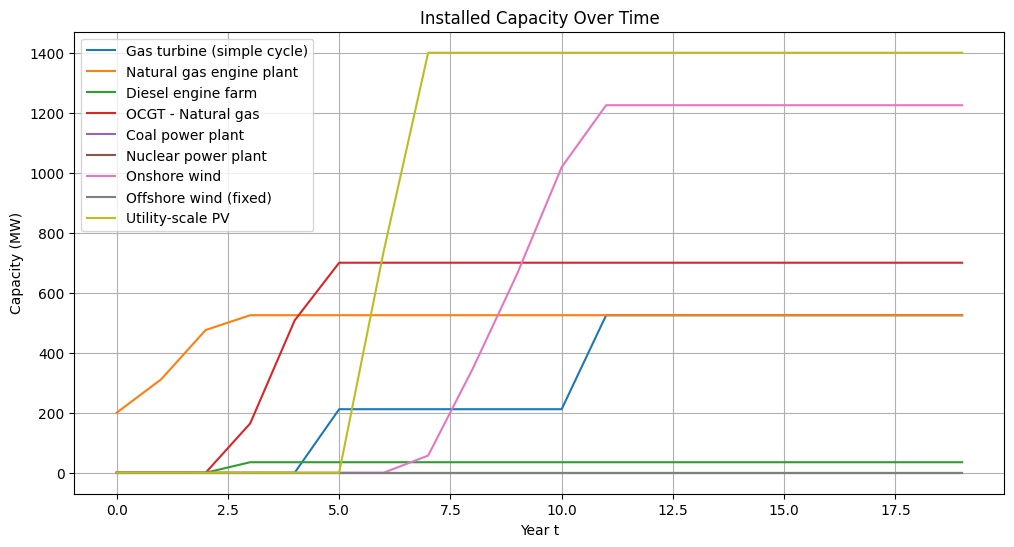

In [65]:
import matplotlib.pyplot as plt

# Build dataframe-like structure
cap_plot = {tech: [capacity[tech,t].X for t in time_periods] 
            for tech in tech_names}

plt.figure(figsize=(12,6))
for tech, vals in cap_plot.items():
    plt.plot(time_periods, vals, label=tech)

plt.title("Installed Capacity Over Time")
plt.xlabel("Year t")
plt.ylabel("Capacity (MW)")
plt.legend()
plt.grid(True)
plt.show()

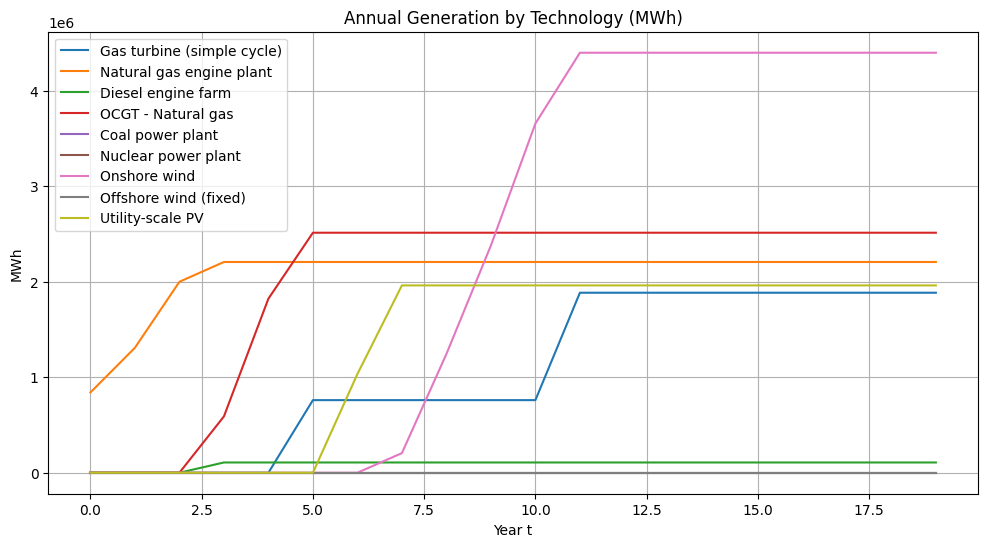

In [66]:
gen_plot = {tech: [energy[tech,t].X for t in time_periods]
            for tech in tech_names}

plt.figure(figsize=(12,6))
for tech, vals in gen_plot.items():
    plt.plot(time_periods, vals, label=tech)

plt.title("Annual Generation by Technology (MWh)")
plt.xlabel("Year t")
plt.ylabel("MWh")
plt.legend()
plt.grid(True)
plt.show()

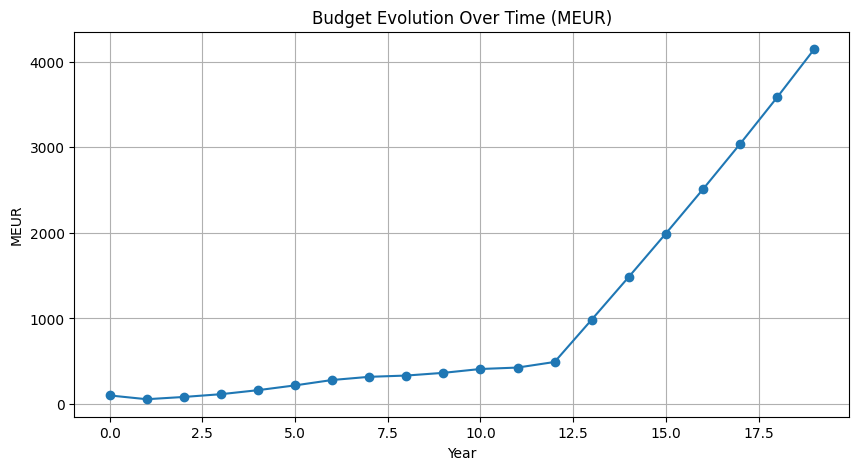

In [67]:
bud = [budget[t].X for t in time_periods]

plt.figure(figsize=(10,5))
plt.plot(time_periods, bud, marker="o")
plt.title("Budget Evolution Over Time (MEUR)")
plt.xlabel("Year")
plt.ylabel("MEUR")
plt.grid(True)
plt.show()

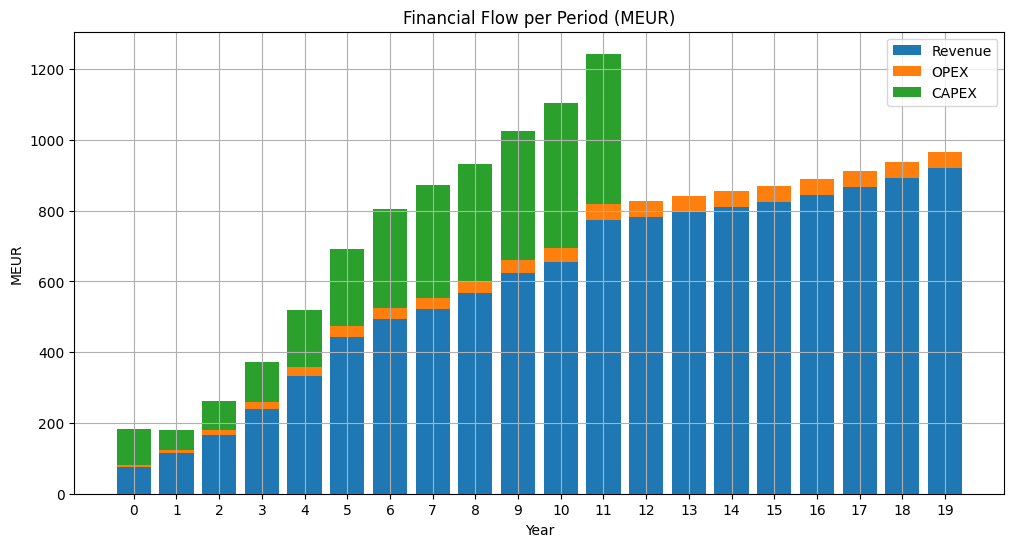

In [68]:
import numpy as np

rev = [revenue[t].X for t in time_periods]
op  = [op_cost[t].X for t in time_periods]
cap = [capex_cost[t].X for t in time_periods]

x = np.arange(len(time_periods))

plt.figure(figsize=(12,6))
plt.bar(x, rev, label="Revenue")
plt.bar(x, op, bottom=rev, label="OPEX")
plt.bar(x, cap, bottom=np.array(rev)+np.array(op), label="CAPEX")

plt.xticks(x, time_periods)
plt.title("Financial Flow per Period (MEUR)")
plt.xlabel("Year")
plt.ylabel("MEUR")
plt.legend()
plt.grid(True)
plt.show()

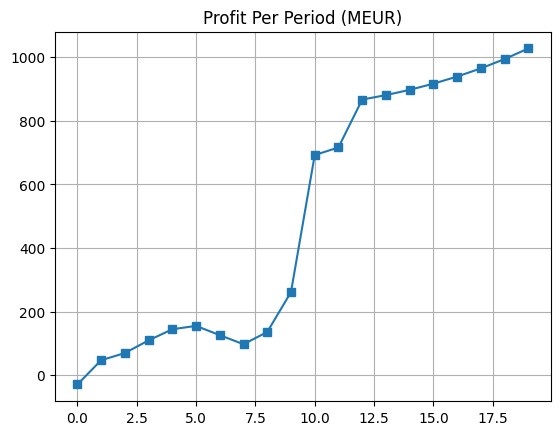

In [13]:
profit_t = [revenue[t].X - op_cost[t].X - capex_cost[t].X 
            for t in time_periods]

plt.plot(time_periods, profit_t, marker="s")
plt.title("Profit Per Period (MEUR)")
plt.grid(True)
plt.show()

#### Model Duals

In [14]:
for t in time_periods:
    constr = model.getConstrByName(f"DemandCap_{t}")
    print(f"Dual Demand Cap t={t}: {constr.Pi:.4f}")

Dual Demand Cap t=0: 0.0000
Dual Demand Cap t=1: 0.0000
Dual Demand Cap t=2: 0.0000
Dual Demand Cap t=3: 0.0000
Dual Demand Cap t=4: 0.0000
Dual Demand Cap t=5: 0.0000
Dual Demand Cap t=6: 0.0000
Dual Demand Cap t=7: 0.0000
Dual Demand Cap t=8: 0.0000
Dual Demand Cap t=9: 0.0001
Dual Demand Cap t=10: 0.0000
Dual Demand Cap t=11: 0.0000
Dual Demand Cap t=12: 0.0000
Dual Demand Cap t=13: 0.0000
Dual Demand Cap t=14: 0.0000
Dual Demand Cap t=15: 0.0000
Dual Demand Cap t=16: 0.0000
Dual Demand Cap t=17: 0.0000
Dual Demand Cap t=18: 0.0000
Dual Demand Cap t=19: 0.0000


In [15]:
for tech in tech_names:
    for t in time_periods:
        c = model.getConstrByName(f"MaxCapacity_{tech}_{t}")
        if c is not None and abs(c.Pi) > 1e-6:
            print(f"{tech}, t={t}: shadow price = {c.Pi}")

In [16]:
for t in time_periods:
    c = model.getConstrByName(f"InvLimit_{t}")   # capex_cost[t] <= budget[t]
    print(f"Shadow price investment limit t{t}: {c.Pi:.4f}")

Shadow price investment limit t0: 8.4407
Shadow price investment limit t1: 4.8919
Shadow price investment limit t2: 2.6760
Shadow price investment limit t3: 1.6783
Shadow price investment limit t4: 0.8610
Shadow price investment limit t5: 0.4283
Shadow price investment limit t6: 0.2820
Shadow price investment limit t7: 0.2118
Shadow price investment limit t8: 0.1164
Shadow price investment limit t9: 0.0000
Shadow price investment limit t10: 0.0000
Shadow price investment limit t11: 0.0000
Shadow price investment limit t12: 0.0000
Shadow price investment limit t13: 0.0000
Shadow price investment limit t14: 0.0000
Shadow price investment limit t15: 0.0000
Shadow price investment limit t16: 0.0000
Shadow price investment limit t17: 0.0000
Shadow price investment limit t18: 0.0000
Shadow price investment limit t19: 0.0000


In [17]:
for t in time_periods[:-1]:
    c = model.getConstrByName(f"BudgetDyn_{t}")
    print(f"Shadow on budget recursion t={t}: {c.Pi:.4f}")

Shadow on budget recursion t=0: 11.1458
Shadow on budget recursion t=1: 6.2539
Shadow on budget recursion t=2: 3.5779
Shadow on budget recursion t=3: 1.8996
Shadow on budget recursion t=4: 1.0385
Shadow on budget recursion t=5: 0.6102
Shadow on budget recursion t=6: 0.3283
Shadow on budget recursion t=7: 0.1164
Shadow on budget recursion t=8: -0.0000
Shadow on budget recursion t=9: -0.0000
Shadow on budget recursion t=10: -0.0000
Shadow on budget recursion t=11: -0.0000
Shadow on budget recursion t=12: -0.0000
Shadow on budget recursion t=13: -0.0000
Shadow on budget recursion t=14: -0.0000
Shadow on budget recursion t=15: -0.0000
Shadow on budget recursion t=16: -0.0000
Shadow on budget recursion t=17: -0.0000
Shadow on budget recursion t=18: -0.0000
